In [74]:
import sys

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import seaborn as sns
import copy

from pylab import rcParams
from scipy.interpolate import interp1d
rcParams['figure.figsize'] = 10, 10

from Models.RealNVP import *
from sklearn import datasets
from Geometry.curves import trainableCurve, BezierCurve
from Geometry.metric import InducedMetricNF

import time

In [75]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [76]:
device = "cuda"

In [77]:
# Only run once, then load saved model
# flow = train(datasets, max_epochs=10000)

In [78]:
# Load flow
path_model = "TrainedModels/flow.pth"
flow = RealNVP(tfm_layers=6, latent_dim=2, device=device).to(device)
# path_model = "TrainedModels/flow_mix.pth"
# flow = RealNVP(tfm_layers=6, latent_dim=2, device=device, distribution="mixture", num_modes=2).to(device)
flow.load_state_dict(torch.load(path_model))
flow.eval()

RealNVP(
  (block_scale): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Tanh()
  )
  (block_trans): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (net_trans): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_f

Text(0.5, 1.0, '$X = g(z)$')

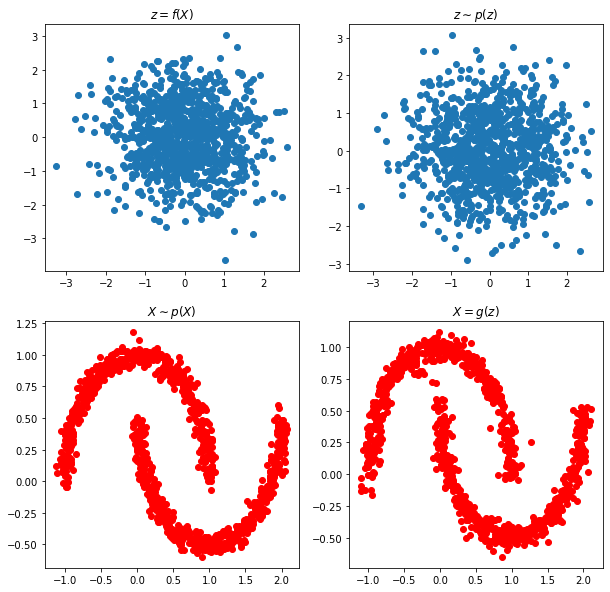

In [79]:
fig = plt.figure()
fig.patch.set_facecolor('w')

noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.to_latent(torch.from_numpy(noisy_moons).to(device))[0].cpu().detach().numpy()

plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## Length Based Optimization

In [80]:
# Discretization of geodesic curve
N_t = 100
latent_dim = 2
# bc0 = torch.Tensor([-2, -2])
# bc1 = torch.Tensor([2, 2])

bc0 = torch.Tensor([-1.3695,  0.0235])
bc1 = torch.Tensor([-0.7177,  0.4285])

### Parameters for training (As used by Mike)
lr_init = 1e0
lr_gamma = 0.95
max_node_count = 20
max_hard_schedules = 5
hard_schedule_factor = 0.3
max_epochs = 1000
val_epoch = 10
verbose = 1
M_batch_size = N_t

# Have a validation set of points to use for validation. Let's use half of N while training.
t_val = torch.linspace(0, 1, N_t)

gamma = trainableCurve(bc0, bc1, max_nodes=max_node_count)
gamma.to(device)

20


trainableCurve(
  (new_nodes): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (4): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (5): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (6): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (7): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (8): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (9): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (10): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (11): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
      (12): Parameter containing: [torch

### Training the Geodesic

In [81]:
def run_gamma_epoch(flow, gamma, optimizer, scheduler, t_val, device, M_batch_size=4, train=True):
    dt = (t_val[1] - t_val[0]).to(device)
    t = t_val.to(device)

    if train:
        gamma.train()

        # Slightly perturb all the t values, such that it isn't sampled at the same points every time.
        perturb = torch.normal(torch.zeros_like(t), 0.1*dt).to(device)
        t = torch.min(torch.max(t+perturb, 0*t), 0*t+1)
    else:
        gamma.eval()
        return flow.energy_in_image_space(gamma, t_val, False, length=True).item(), (flow.sesl_loss(gamma, t_val, False) / t_val.shape[0]).item()

    length = 0
    # loss_epoch = 0
    # steps = 0
    gamma.zero_grad()
    # TODO: Increase batch_size
    for batch in range(0, t_val.shape[0], M_batch_size):
        with torch.set_grad_enabled(True):
            # Here loss is the length
            loss = flow.sesl_loss(gamma, t[batch:batch+M_batch_size], True)
            # TODO: Inefficient
            length += flow.energy_in_image_space(gamma, t[batch:batch+M_batch_size], True, length=True)
            # loss_epoch += loss.item()
            # steps += 1

            loss.backward()

    if train:
        optimizer.step()
        scheduler.step()

    return length.item()
    # return length.item(), loss_epoch / steps

In [82]:
# Start with straight line
best_gamma = copy.deepcopy(gamma)

# Now we are measuring in image space
best_length = flow.energy_in_image_space(best_gamma, t_val, False, length=True)

# Let tolerance depend on the length of straight line.
length_tol = best_length / 100.

print(f"Straight curve length in image space: {best_length:.3f}")

optimizer = torch.optim.Adam(gamma.parameters(), lr=lr_init, weight_decay=1e-4)

# Multiplies the given lr with lambda every call to the scheduler
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: lr_gamma)

hard_schedules = 0
length_history = [best_length]
loss_history = []

# Just a hack to disregard the fact when no better curve was found
tick = time.perf_counter()
tock = tick - 100
for epoch in range(max_epochs):
    if (epoch+1) % val_epoch:
        # Training: best_gamma unchanged
        run_gamma_epoch(flow, gamma, optimizer, scheduler, t_val, device, M_batch_size=M_batch_size, train=True)
    else:
        # Validation
        length, loss_epoch = run_gamma_epoch(flow, gamma, optimizer, scheduler, t_val, device, M_batch_size=M_batch_size, train=False)
        length_history.append(length)
        loss_history.append(loss_epoch)
        if verbose >= 1:
            print('-'*10)
            print(f"Learning rate: {optimizer.param_groups[0]['lr']:.5e}")
            print(f"Epoch[{epoch+1:04d}/{max_epochs}]: Length: {length:.3f}, SESL Loss: {loss_epoch:.3f}")

        length_improvement = best_length - length
        if length < best_length:
            # Store current best network for minimal length
            if verbose >= 1:
                print("Found better curve!")
            best_gamma = copy.deepcopy(gamma)
            best_length = length
            tock = time.perf_counter()

        if length_improvement < length_tol:
            # In case the loss increases, we first wanna rapidly decrease lr before we add nodes.
            # We restart from the best solution when adding nodes or decreasing LR
            if hard_schedules >= max_hard_schedules:
                ### New Node
                if best_gamma.nodecount >= max_node_count:
                    print("Node limit reached!")
                    break
                if verbose >= 1:
                    print("*** Adding node ***")
                best_gamma.add_node()

            ### Set gamma, and Reset best_gamma so it isn't trained
            gamma = best_gamma
            best_gamma = copy.deepcopy(best_gamma)

            # Re-initialize the optimizer to only the gamma parameters with gradients
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, gamma.parameters()), lr=lr_init, weight_decay=1e-4)
            scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: lr_gamma)

            if hard_schedules < max_hard_schedules:
                if verbose >= 1:
                    print("* Decreasing LR *")
                hard_schedules += 1
                optimizer.param_groups[0]['lr'] *= hard_schedule_factor ** hard_schedules
            else:
                # Reset hardSchedules when adding new node
                hard_schedules = 0

print(f"New curve length: {best_length:.3f}")

if tock < tick:
    tock = time.perf_counter()

print(f"Time for convergence: {tock - tick:.3f} secs")

Straight curve length in image space: 0.851
----------
Learning rate: 6.30249e-01
Epoch[0010/1000]: Length: 4.233, SESL Loss: 0.471
* Decreasing LR *
----------
Learning rate: 1.89075e-01
Epoch[0020/1000]: Length: 0.831, SESL Loss: 0.006
Found better curve!
----------
Learning rate: 1.19164e-01
Epoch[0030/1000]: Length: 0.830, SESL Loss: 0.008
Found better curve!
* Decreasing LR *
----------
Learning rate: 5.67224e-02
Epoch[0040/1000]: Length: 0.807, SESL Loss: 0.002
Found better curve!
----------
Learning rate: 3.57493e-02
Epoch[0050/1000]: Length: 0.812, SESL Loss: 0.003
* Decreasing LR *
----------
Learning rate: 1.70167e-02
Epoch[0060/1000]: Length: 0.807, SESL Loss: 0.001
* Decreasing LR *
----------
Learning rate: 5.10502e-03
Epoch[0070/1000]: Length: 0.807, SESL Loss: 0.001
* Decreasing LR *
----------
Learning rate: 1.53151e-03
Epoch[0080/1000]: Length: 0.807, SESL Loss: 0.002
Found better curve!
*** Adding node ***
----------
Learning rate: 6.30249e-01
Epoch[0090/1000]: Length

## Visualization

In [54]:
curve_pts = gamma(t_val)[0]
image_pts, log_det_j = flow.to_image(curve_pts[:, None, :])
image_pts = torch.squeeze(image_pts, axis=1)
image_gds = tensor_linspace(image_pts[0, :], image_pts[-1, :], image_pts.shape[0])
latent_gds, _ = flow.to_latent(image_gds)

Text(0.5, 1.0, '$X = g(z)$')

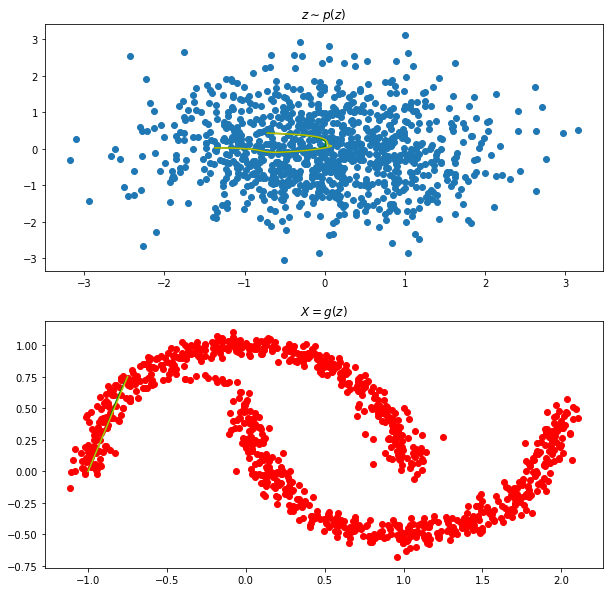

In [55]:
fig = plt.figure()
fig.patch.set_facecolor('w')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(211)
plt.scatter(z[:, 0], z[:, 1])
plt.plot(curve_pts[:, 0].cpu().detach().numpy(), curve_pts[:, 1].cpu().detach().numpy(), c='g')
plt.plot(latent_gds[:, 0].cpu().detach().numpy(), latent_gds[:, 1].cpu().detach().numpy(), c='y')

plt.title(r'$z \sim p(z)$')

plt.subplot(212)
x = flow.sample(1000).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.plot(image_pts[:, 0].cpu().detach().numpy(), image_pts[:, 1].cpu().detach().numpy(), c='g')
plt.plot(image_gds[:, 0].cpu().detach().numpy(), image_gds[:, 1].cpu().detach().numpy(), c='y')
plt.title(r'$X = g(z)$')

In [56]:
curve_pts = best_gamma(t_val)[0]
image_pts, log_det_j = flow.to_image(curve_pts[:, None, :])
latent_gds, _ = flow.to_latent(image_gds)

Text(0.5, 1.0, '$X = g(z)$')

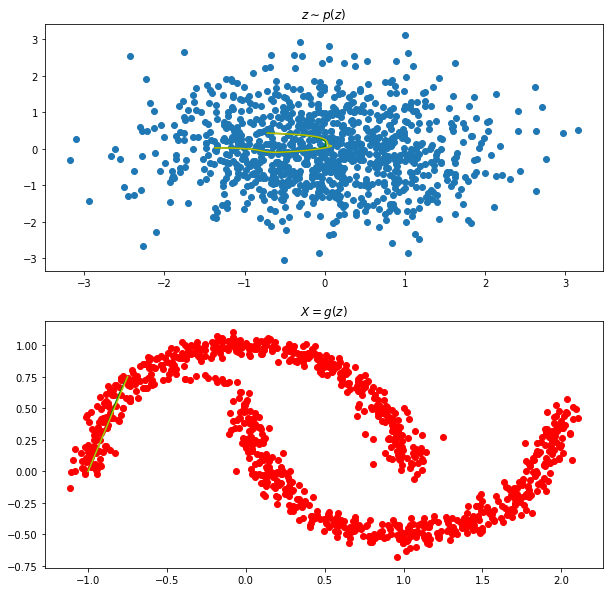

In [57]:
fig = plt.figure()
fig.patch.set_facecolor('w')

plt.subplot(211)
plt.scatter(z[:, 0], z[:, 1])
plt.plot(curve_pts[:, 0].cpu().detach().numpy(), curve_pts[:, 1].cpu().detach().numpy(), c='g')
plt.plot(latent_gds[:, 0].cpu().detach().numpy(), latent_gds[:, 1].cpu().detach().numpy(), c='y')
plt.title(r'$z \sim p(z)$')

plt.subplot(212)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.plot(image_pts[:, 0, 0].cpu().detach().numpy(), image_pts[:, 0, 1].cpu().detach().numpy(), c='g')
plt.plot(image_gds[:, 0].cpu().detach().numpy(), image_gds[:, 1].cpu().detach().numpy(), c='y')
plt.title(r'$X = g(z)$')

In [58]:
flow.energy_in_image_space(best_gamma, t_val, length=True)

array(0.7927051, dtype=float32)

In [59]:
metric_space = InducedMetricNF(flow, 2, 2)
with torch.set_grad_enabled(False):
    res, diff = best_gamma(t_val.to(device))
    g = res.detach().cpu().numpy()
    dg = diff.detach().cpu().numpy()

dt = t_val[1] - t_val[0]
best_length = metric_space.curveLength(dt, g, dg, M_batch_size=t_val.shape[0])
best_length

tensor(0.8001)

## Loss History

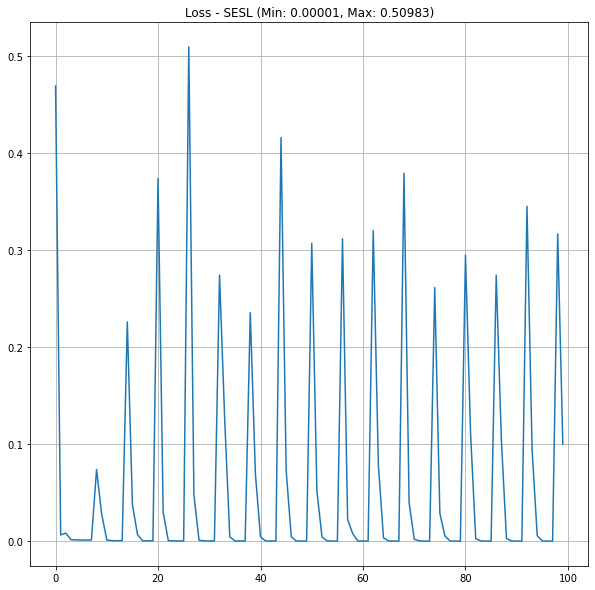

In [67]:
loss_history = np.array(loss_history)
fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(loss_history)
plt.title(f"Loss - SESL (Min: {loss_history.min():.5f}, Max: {loss_history.max():.5f})")
plt.grid()
plt.savefig("Outputs/loss_sesl.png")

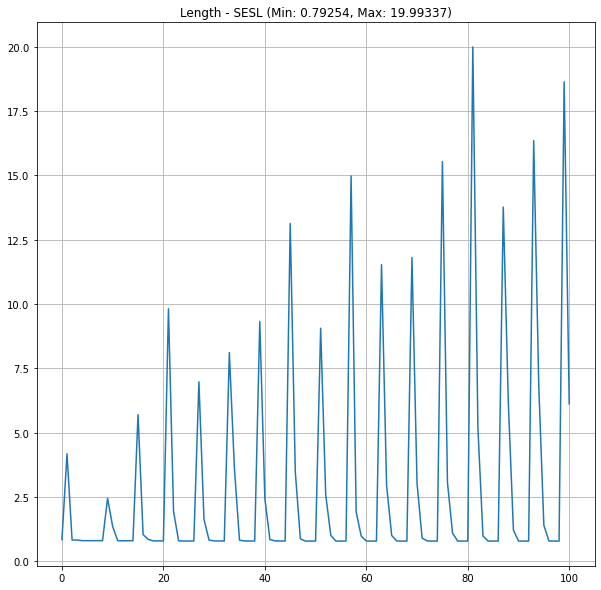

In [68]:
length_history = np.array(length_history)
fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(length_history)
plt.title(f"Length - SESL (Min: {length_history.min():.5f}, Max: {length_history.max():.5f})")
plt.grid()
plt.legend
plt.savefig("Outputs/len_sesl.png")